# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [113]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


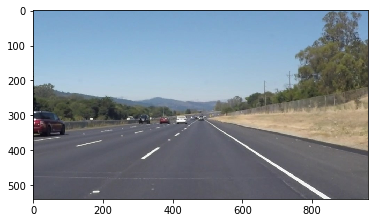

In [114]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [413]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def draw_lines_improved(img, lines, color=[255, 0, 0], thickness=10):
    # Draw lines in left and right lane by using extrapolated approach
    #print(lines)
    flag = True
    
    left_lines = []
    right_lines = []
    
    mid = img.shape[1]/2
    min_slope = 0.5
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            
            if abs(slope) > min_slope:
                if (x1 < mid) and (x2 < mid):
                    left_lines.append([x1,y1])
                    left_lines.append([x2,y2])
                if (x1 > mid) and (x2 > mid):
                    right_lines.append([x1,y1])
                    right_lines.append([x2,y2])
            
    
    ll_x = [item[0] for item in left_lines]    
    ll_y = [item[1] for item in left_lines]
    rl_x = [item[0] for item in right_lines]
    rl_y = [item[1] for item in right_lines]
        
    # Draw lines
    if (len(ll_x) > 0):
        left_slope, left_intercept = np.polyfit(ll_x, ll_y ,1)
    else:
        flag = False 
    
    if (len(rl_x) > 0):
        right_slope, right_intercept = np.polyfit(rl_x, rl_y ,1)
    else:
        flag = False 
    
    
    y1 = img.shape[0]
    y2 = img.shape[0] * (1 - 0.38)
    
    if flag:
        x_left1 = (y1 - left_intercept)/left_slope
        x_left2 = (y2 - left_intercept)/left_slope
        
        x_right1 = (y1 - right_intercept)/right_slope
        x_right2 = (y2 - right_intercept)/right_slope
     
        cv2.line(img, (int(x_left1), y1), (int(x_left2), int(y2)), color, thickness)
        cv2.line(img, (int(x_right1), y1), (int(x_right2), int(y2)), color, thickness)
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    draw_lines_improved(line_img, lines)

    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# Source: https://github.com/georgesung/road_lane_line_detection
def filter_pixels(image):
    # Filter white pixels
    white_threshold = 200
    lower_white = np.array([white_threshold, white_threshold, white_threshold])
    upper_white = np.array([255, 255, 255])
    white_mask = cv2.inRange(image, lower_white, upper_white)
    white_image = cv2.bitwise_and(image, image, mask=white_mask)

    # Filter yellow pixels
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([90,100,100])
    upper_yellow = np.array([110,255,255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    yellow_image = cv2.bitwise_and(image, image, mask=yellow_mask)

    # Combine the two above images
    image2 = cv2.addWeighted(white_image, 1., yellow_image, 1., 0.)

    return image2

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [414]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

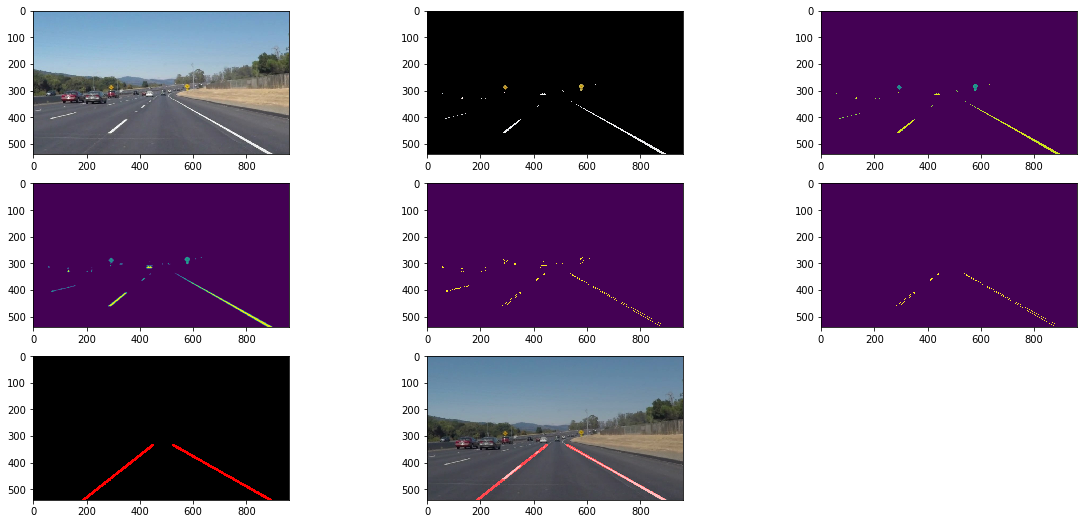

In [438]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
import os
images = os.listdir("test_images/")

final_images = []


for idx,val in enumerate(images):
    #reading in an image
    image = mpimg.imread('test_images/' + images[idx])
    final_images.append(image)

    image2 = filter_pixels(image)
    final_images.append(image2)

    height = image.shape[0]
    width = image.shape[1]
    gImg = grayscale(image2)
    final_images.append(gImg)

    blurImg = gaussian_blur(gImg,5)
    final_images.append(blurImg)

    edges = canny(blurImg,40,120)
    final_images.append(edges)

    #print(edges.shape)
    trap = [np.array([[(75,height),(width*3.5/8, height/1.7), (width*4.5/8, height/1.7), (width,height)]], dtype=np.int32)]
    #print(trap)
    roi = region_of_interest(edges,trap)
    final_images.append(roi)

    # Hough paramet/ers
    rho = 2
    theta = np.pi/180
    threshold = 30
    min_line_len = 20
    max_line_gap = 20


    hLines = hough_lines(roi,rho,theta,threshold,min_line_len,max_line_gap)
    final_images.append(hLines)

    result = weighted_img(hLines,image)
    final_images.append(result)
    break

fig = plt.figure(figsize=(20, len(final_images)+1))

# Create subplots in figure
for r in range(1,len(final_images)+1):
    fig.add_subplot(3,3,r)
    plt.imshow(final_images[r-1])


plt.show()

#### Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [416]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [431]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    #image2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #hsv = cv2.cvtColor(image2, cv2.COLOR_RGB2HSV)
    #yellow = cv2.inRange(hsv, (20, 80, 80), (25, 255, 255))
    #white = cv2.inRange(hsv, (0, 0, 180), (255, 25, 255))
    #gImg = cv2.bitwise_or(yellow, white)
    image2 = filter_colors(image)
    height = image.shape[0]
    width = image.shape[1]
    gImg = grayscale(image2)
    blurImg = gaussian_blur(gImg,5)
    edges = canny(blurImg,40,120)
    #print(edges.shape)
    trap = [np.array([[(75,height),(width*3.5/8, height/1.7), (width*4.5/8, height/1.7), (width,height)]], dtype=np.int32)]
    #print(trap)
    roi = region_of_interest(edges,trap)
    # Hough paramet/ers
    rho = 2
    theta = np.pi/180
    threshold = 30
    min_line_len = 20
    max_line_gap = 20

    hLines = hough_lines(roi,rho,theta,threshold,min_line_len,max_line_gap)
    result = weighted_img(hLines,image)

    return result

Let's try the one with the solid white lane on the right first ...

In [432]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  3%|▎         | 6/222 [00:00<00:03, 55.30it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

  9%|▊         | 19/222 [00:00<00:03, 57.81it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 16%|█▌        | 35/222 [00:00<00:02, 66.09it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 23%|██▎       | 51/222 [00:00<00:02, 68.57it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 30%|██▉       | 66/222 [00:00<00:02, 70.27it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 36%|███▋      | 81/222 [00:01<00:02, 70.27it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 43%|████▎     | 96/222 [00:01<00:01, 70.96it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 50%|█████     | 111/222 [00:01<00:01, 64.08it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 57%|█████▋    | 126/222 [00:01<00:01, 66.87it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 60%|█████▉    | 133/222 [00:01<00:01, 64.52it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 66%|██████▌   | 147/222 [00:02<00:01, 56.66it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 72%|███████▏  | 160/222 [00:02<00:01, 57.04it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 75%|███████▍  | 166/222 [00:02<00:01, 52.77it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 80%|████████  | 178/222 [00:02<00:00, 50.72it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 86%|████████▌ | 190/222 [00:03<00:00, 51.08it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 91%|█████████▏| 203/222 [00:03<00:00, 56.09it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 98%|█████████▊| 218/222 [00:03<00:00, 62.90it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

100%|█████████▉| 221/222 [00:03<00:00, 62.18it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.99 s, sys: 554 ms, total: 4.55 s
Wall time: 3.92 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [426]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [427]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  1%|          | 5/682 [00:00<00:13, 49.87it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

  2%|▏         | 13/682 [00:00<00:12, 55.45it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


  3%|▎         | 19/682 [00:00<00:11, 55.36it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

  5%|▍         | 32/682 [00:00<00:11, 58.60it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

  6%|▌         | 40/682 [00:00<00:10, 62.54it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


  7%|▋         | 47/682 [00:00<00:10, 63.35it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

  9%|▉         | 62/682 [00:00<00:09, 66.03it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 11%|█▏        | 78/682 [00:01<00:08, 69.34it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 13%|█▎        | 92/682 [00:01<00:08, 67.91it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 16%|█▌        | 106/682 [00:01<00:08, 68.14it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 18%|█▊        | 122/682 [00:01<00:07, 70.51it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 20%|██        | 138/682 [00:02<00:07, 71.76it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 23%|██▎       | 154/682 [00:02<00:07, 71.97it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 24%|██▍       | 162/682 [00:02<00:07, 70.73it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 25%|██▍       | 170/682 [00:02<00:07, 70.13it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 26%|██▌       | 178/682 [00:02<00:07, 69.08it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 28%|██▊       | 192/682 [00:02<00:07, 65.80it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 30%|███       | 207/682 [00:03<00:07, 67.23it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 33%|███▎      | 222/682 [00:03<00:06, 69.94it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 35%|███▍      | 237/682 [00:03<00:06, 69.03it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 37%|███▋      | 252/682 [00:03<00:06, 70.50it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 39%|███▉      | 268/682 [00:03<00:05, 71.91it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 40%|████      | 276/682 [00:04<00:05, 71.17it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 42%|████▏     | 284/682 [00:04<00:05, 72.22it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 43%|████▎     | 292/682 [00:04<00:05, 70.84it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 44%|████▍     | 300/682 [00:04<00:05, 70.78it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 45%|████▌     | 308/682 [00:04<00:05, 69.56it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 48%|████▊     | 324/682 [00:04<00:05, 70.27it/s]


(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 5

 50%|████▉     | 340/682 [00:04<00:04, 70.88it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 51%|█████     | 348/682 [00:05<00:04, 70.26it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 52%|█████▏    | 356/682 [00:05<00:04, 71.44it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 53%|█████▎    | 364/682 [00:05<00:04, 70.54it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)


 55%|█████▍    | 372/682 [00:05<00:04, 70.00it/s]

[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 56%|█████▌    | 380/682 [00:05<00:04, 69.39it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 57%|█████▋    | 387/682 [00:05<00:04, 68.71it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 58%|█████▊    | 394/682 [00:05<00:04, 68.99it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 59%|█████▉    | 402/682 [00:05<00:04, 69.75it/s]


(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 60%|█████▉    | 409/682 [00:05<00:03, 68.49it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 61%|██████    | 416/682 [00:06<00:03, 68.48it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 62%|██████▏   | 423/682 [00:06<00:03, 68.76it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 63%|██████▎   | 430/682 [00:06<00:03, 68.49it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 64%|██████▍   | 437/682 [00:06<00:03, 68.11it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 65%|██████▌   | 445/682 [00:06<00:03, 69.12it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)

 66%|██████▋   | 453/682 [00:06<00:03, 69.81it/s]


[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
      

 68%|██████▊   | 467/682 [00:06<00:03, 69.66it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 71%|███████   | 483/682 [00:06<00:02, 72.11it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 73%|███████▎  | 499/682 [00:07<00:02, 73.00it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 76%|███████▌  | 515/682 [00:07<00:02, 72.79it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 77%|███████▋  | 523/682 [00:07<00:02, 72.87it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 78%|███████▊  | 531/682 [00:07<00:02, 72.45it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 79%|███████▉  | 539/682 [00:07<00:01, 71.64it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 80%|████████  | 547/682 [00:07<00:01, 71.70it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 81%|████████▏ | 555/682 [00:07<00:01, 71.29it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)


 83%|████████▎ | 563/682 [00:08<00:01, 70.74it/s]

[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 84%|████████▎ | 571/682 [00:08<00:01, 70.09it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 85%|████████▍ | 579/682 [00:08<00:01, 69.92it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 86%|████████▌ | 586/682 [00:08<00:01, 69.12it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)

 87%|████████▋ | 593/682 [00:08<00:01, 68.90it/s]


[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 88%|████████▊ | 600/682 [00:08<00:01, 68.82it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 89%|████████▉ | 608/682 [00:08<00:01, 70.10it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 90%|█████████ | 616/682 [00:08<00:00, 70.39it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 91%|█████████▏| 624/682 [00:08<00:00, 71.96it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 54

 93%|█████████▎| 632/682 [00:09<00:00, 71.73it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 94%|█████████▍| 640/682 [00:09<00:00, 72.60it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 95%|█████████▌| 648/682 [00:09<00:00, 70.67it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 96%|█████████▌| 656/682 [00:09<00:00, 70.04it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 97%|█████████▋| 664/682 [00:09<00:00, 69.39it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


 98%|█████████▊| 671/682 [00:09<00:00, 69.37it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


100%|█████████▉| 681/682 [00:09<00:00, 69.72it/s]

(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]
(540, 960)
[array([[[ 75, 540],
        [420, 317],
        [540, 317],
        [960, 540]]], dtype=int32)]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 11.4 s, sys: 1.53 s, total: 12.9 s
Wall time: 10.1 s


In [428]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [433]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  2%|▏         | 4/251 [00:00<00:07, 31.57it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


  5%|▌         | 13/251 [00:00<00:07, 33.48it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


  7%|▋         | 17/251 [00:00<00:07, 33.35it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


  9%|▉         | 22/251 [00:00<00:06, 35.41it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 10%|█         | 26/251 [00:00<00:06, 35.41it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 12%|█▏        | 31/251 [00:00<00:05, 37.66it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 14%|█▍        | 36/251 [00:00<00:05, 38.86it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 16%|█▋        | 41/251 [00:01<00:05, 40.45it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 18%|█▊        | 45/251 [00:01<00:05, 39.05it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 20%|█▉        | 49/251 [00:01<00:05, 38.76it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 21%|██        | 53/251 [00:01<00:05, 38.53it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 23%|██▎       | 57/251 [00:01<00:05, 38.52it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 24%|██▍       | 61/251 [00:01<00:04, 38.08it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 26%|██▌       | 65/251 [00:01<00:04, 37.84it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 27%|██▋       | 69/251 [00:01<00:04, 37.39it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)


 31%|███       | 78/251 [00:02<00:04, 37.47it/s]

[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)

 34%|███▍      | 86/251 [00:02<00:04, 35.89it/s]


[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 36%|███▌      | 90/251 [00:02<00:04, 33.00it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 39%|███▉      | 99/251 [00:02<00:04, 34.89it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
       

 43%|████▎     | 108/251 [00:02<00:03, 37.24it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 46%|████▌     | 116/251 [00:03<00:03, 37.52it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 48%|████▊     | 120/251 [00:03<00:03, 36.65it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 49%|████▉     | 124/251 [00:03<00:03, 37.18it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 51%|█████     | 128/251 [00:03<00:03, 35.21it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 53%|█████▎    | 132/251 [00:03<00:03, 35.59it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 54%|█████▍    | 136/251 [00:03<00:03, 33.89it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 56%|█████▌    | 140/251 [00:03<00:03, 34.28it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 57%|█████▋    | 144/251 [00:03<00:03, 34.40it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)

 59%|█████▉    | 148/251 [00:04<00:02, 34.90it/s]


[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 61%|██████    | 152/251 [00:04<00:02, 35.17it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 62%|██████▏   | 156/251 [00:04<00:02, 35.53it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 64%|██████▎   | 160/251 [00:04<00:02, 35.19it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 65%|██████▌   | 164/251 [00:04<00:02, 35.47it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 67%|██████▋   | 168/251 [00:04<00:02, 33.90it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 69%|██████▊   | 172/251 [00:04<00:02, 32.20it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 70%|███████   | 176/251 [00:04<00:02, 30.37it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 72%|███████▏  | 180/251 [00:05<00:02, 30.88it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 73%|███████▎  | 184/251 [00:05<00:02, 32.08it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 75%|███████▍  | 188/251 [00:05<00:01, 31.79it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 78%|███████▊  | 196/251 [00:05<00:01, 31.97it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 80%|███████▉  | 200/251 [00:05<00:01, 31.57it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 81%|████████▏ | 204/251 [00:05<00:01, 32.05it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 83%|████████▎ | 208/251 [00:05<00:01, 32.62it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 84%|████████▍ | 212/251 [00:06<00:01, 33.67it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 86%|████████▌ | 216/251 [00:06<00:01, 33.93it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 88%|████████▊ | 220/251 [00:06<00:00, 34.32it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 89%|████████▉ | 224/251 [00:06<00:00, 35.24it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 91%|█████████ | 228/251 [00:06<00:00, 36.08it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 92%|█████████▏| 232/251 [00:06<00:00, 36.05it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 94%|█████████▍| 236/251 [00:06<00:00, 36.49it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 96%|█████████▌| 240/251 [00:06<00:00, 37.01it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 98%|█████████▊| 245/251 [00:06<00:00, 38.04it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


 99%|█████████▉| 249/251 [00:06<00:00, 38.53it/s]

(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]
(720, 1280)
[array([[[  75,  720],
        [ 560,  423],
        [ 720,  423],
        [1280,  720]]], dtype=int32)]


100%|██████████| 251/251 [00:07<00:00, 35.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 7.7 s, sys: 1.2 s, total: 8.9 s
Wall time: 7.68 s


In [434]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))